## <center>处理 Seq2Seq 任务</center>

### 1 Seq2Seq 任务介绍
seq2seq 任务可以理解为,从一个 sequence 做某些工作映射到另外一个 sequence 的任务. sequence 可以理解为一个字符串序列,在给定一个字符串序列后,希望得到与之对应的另一个字符串序列,如翻译后的,语义上对应的. seq2seq 不关心输入和输出的序列是否长度对应.

Encoder-Decoder 框架的工作机制是: 先使用 Encoder 将输入映射到语义空间(通过 Encoder 网络生成的特征向量),得到一个固定维数的向量,这个向量就表示输入的语义,然后再使用 Decoder 将这个语义解码,获取需要的输出.
<br/><br/>
<center><img src="./img/13/1.png" width="500"></center>
<br/>
在 Encoder-Decoder 框架有两个输入:一个是 $x$ 输入作为 Encoder 的输入,另一个是 $y$ 输入作为 Decoder 输入, $x$ 和 $y$ 依次按照各自的顺序传入网络.从中可以看出,训练过程中,标签 $y$ 既参与计算 loss, 又参与节点运算,而不是像前面学习的其他网络只用来做 loss 监督. 中间隐含节点 C 就是 Encoder 的输出,同时也是 Decoder 中 cell 的初始状态.

### 2 Tensorflow 中的 seq2seq (旧版)
在 Tensorflow 中有两套 Seq2Seq 的接口,一套是 Tensorflow 1.0 版本之前的接口,在 $ tf.contrib.legacy\_seq2seq$ 下,新版本的接口在 $tf.contrib.seq2seq$ 下,旧接口的功能相对简单,是静态展开的网络模型,而新接口,使用的是动态展开的网络模型,并提供了训练和应用两种场景的 Helper 类封装.从使用角度来看,旧接口简单,新接口更加灵活,需要自己组建 Encoder 和 Decoder 并通过函数把他们手动连接起来.
```python
tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_inputs,decoder_inputs,cell,dtype=tf.float32)
参数说明如下:
+ encoder_inputs: 一个形状为 [batch_size * input_size] 的 list
+ decoder_inputs: 一个形状为 [batch_size * input_size] 的 list
+ cell: 定义的 cell 网络
+ dtype: encoder_inputs 和 decoder_inputs 中的类型,默认是 tf.float32
+ 返回值: outputs 和 state.outputs 为 [batch_size,output_size]的张量, state 为 [batch_size,cell.state_size], cell.state_size 可以表示一个或者多个子 cell 状态.
```

### 3 使用 basic_rnn_seq2seq 拟合曲线
通过 sin 与 cos 进行叠加,产生无规律的模型曲线,使用 seq2seq 模式对其进行学习,拟合特征,从而达到可以预测下一时刻数据的效果.

#### (1) 定义模拟样本函数
定义两个曲线 sin 和 cos, 通过随机值将其变形偏移,将两个曲线叠加:

In [1]:
import tensorflow  as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [2]:
# 生成训练样本
def do_generate_x_y(isTrain,batch_size,seq_len):
    batch_x = []
    batch_y = []
    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        # 随机变换频率和振幅
        freq_rand = (random.random() - 0.5)/1.5*15 + 0.5
        amp_rand = random.random() + 0.1
        
        sin_data = amp_rand * np.sin(np.linspace(seq_len/15.0 * freq_rand * 0.0 * math.pi + 
                                                 offset_rand,seq_len/15.0 * freq_rand * 3.0 * math.pi 
                                                 + offset_rand,seq_len*2))
        offset_rand = random.random() * 2 * math.pi
        # 随机变换频率和振幅
        freq_rand = (random.random() - 0.5)/1.5*15 + 0.5
        amp_rand = random.random()*1.2
        
        cos_data = amp_rand * np.sin(np.linspace(seq_len/15.0 * freq_rand * 0.0 * math.pi + 
                                                 offset_rand,seq_len/15.0 * freq_rand * 3.0 * math.pi 
                                                 + offset_rand,seq_len*2))
        add_data = sin_data + cos_data
        # 前 seq_len 个数据作为 encoder_inputs , 后 seq_len 个数据作为 decoder_inputs
        # 这一步将 add_data 每一个数都拆分出来了
        batch_x.append(np.array([add_data[:seq_len]]).T)
        batch_y.append(np.array([add_data[seq_len:]]).T)
    # 当前 batch_x 的形状为 (batch_size,seq_length,1)
    # 当前shape: (batch_size,seq_length,output_dim)
    batch_x = np.array(batch_x).transpose((1,0,2))
    batch_y = np.array(batch_y).transpose((1,0,2))
    # 转换后shape: (seq_length,batch_size,output_dim)
    return batch_x,batch_y

# 生成 15 个连续序列,将 cos 和 sin 随机偏移变化后的值叠加起来.
def generate_data(isTrain,batch_size):
    seq_len = 15
    if isTrain:
        return do_generate_x_y(isTrain,batch_size,seq_len)
    else:
        return do_generate_x_y(isTrain,batch_size,seq_len*2)

将该曲线按照 30 个序列一组的样式组成训练用的样本. 30 个序列分成两部分:一部分当成现在的序列 batch_x,一部分当前未来序列 batch_y

#### (2) 定义参数及网络结构
前面介绍过 basic_rnn_seq2seq 的输入是一个 list,需要定义三个 list (encoder_input,expected_output,decoder_input), 按照时间顺序的数量来循环创建占位符,并使用 append 方法放到 list 中.

网络模型定义为 2 层的循环网络,每层 12 个 GRUCell. 用 MultiRNNCell 将 cell 定义好后与前面的 list 一起传入 basic_rnn_seq2seq 中.

生成的结果为 dec_outputs, dec_output 中每个时刻有 12 个 GRUCell 的输出, 所以还需要通过循环在每个时刻下加一个全连接层,将其转为输出维度 output_dim 的节点.

In [3]:
sample_now,sample_future = generate_data(isTrain=True,batch_size=10)
print("training examples: ")
print(sample_now.shape)
print("(seq_length,batch_size,output_dim)")

seq_length = sample_now.shape[0]
batch_size = 10

# 输出维度为 1
output_dim = input_dim = sample_now.shape[-1]
# 隐含单元数量
hidden_dim = 12
# encoder 和 decoder 都有两层循环神经网络
layers_stacked_count = 2
learning_rate = 0.01
iters = 1000
lambda_l2_reg = 0.003

tf.reset_default_graph()

encoder_input = []
decoder_input = []
# 期望输出的标签
expected_output = []

#　输入的数据都是(seq_length,batch_size,input_dim)
for i in range(seq_length):
    encoder_input.append(tf.placeholder(dtype=tf.float32,shape=(None,input_dim)))
    expected_output.append(tf.placeholder(dtype=tf.float32,shape=(None,output_dim)))
    decoder_input.append(tf.placeholder(dtype = tf.float32,shape=(None,input_dim)))

# 这里使用的是多层 RNN
tcells = []
for i in range(layers_stacked_count):
    tcells.append(tf.contrib.rnn.GRUCell(num_units=hidden_dim))

mcells = tf.contrib.rnn.MultiRNNCell(cells=tcells)
# 返回值为(batch_size,hidden_dim),每个 cell 输出都有 hidden_dim 维
# 而对应的结果只有一维,所以需要使用一个全连接层将其转换成 1 维
decoder_outputs,_ = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(
    encoder_input,decoder_input,mcells,dtype=tf.float32)

# 将 batch 中的每一个样本做一次全连接,输出的形状为[batch_size,output_dim], 
# 这和 expected_output 的形状相同.

reshape_outputs = []
for i in decoder_outputs:
    reshape_outputs.append(tf.contrib.layers.fully_connected(i,output_dim,activation_fn=None))

training examples: 
(15, 10, 1)
(seq_length,batch_size,output_dim)


#### (3) 定义 loss 函数及优化器
为了防止过拟合,对 basic_rnn_seq2seq 循环网络中的参数使用 l2_loss 正则,由于最后一个全连接只起到转换作用,就忽略不做 l2_loss 正则了(也可以加上,效果没有影响)

In [4]:
output_loss = 0.0
# 计算所有样本的平方损失
for pred,label in zip(reshape_outputs,expected_output):
    output_loss += tf.reduce_mean(tf.pow(pred-label,2))
reg_loss = 0.0
# 可以通过这种通用的方式来求 loss 值
for var in tf.trainable_variables():
    if not (" full_connected" in var.name):
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(var))
loss = output_loss + lambda_l2_reg * reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

预测结果与真实结果的平方差再加上 l2 的 loss 值,作为输出的 loss 值.

#### (4) 启动 session 开始训练
在 session 中将训练和测试单独封装成两个函数, 在 train_batch 函数里先取指定批次数据,通过循环来填充到 encoder_input 和 expected_output 列表中.

In [5]:
sess = tf.Session()

def train_batch(batch_size):
    X,Y = generate_data(isTrain=True,batch_size=batch_size)
    # 在训练过程中,生成训练数据和预测数据
    feed_dict = {encoder_input[t]:X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]:Y[t] for t in range(len(expected_output))})
    # 在 encoder-decoder 模型中,decoder 的输入就是,对应的标签偏移一位
    c = np.concatenate(([np.zeros_like(Y[0])],Y[:-1]),axis = 0)
    feed_dict.update({decoder_input[t]:c[t] for t in range(len(c))})
    _,loss_t = sess.run([optimizer,loss],feed_dict)
    return loss_t
def test_batch(batch_size):
    X,Y = generate_data(isTrain=True,batch_size=batch_size)
    feed_dict = {encoder_input[t]:X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]:Y[t] for t in range(len(expected_output))})
    c = np.concatenate(([np.zeros_like(Y[0])],Y[:-1]),axis = 0)
    feed_dict.update({decoder_input[t]:c[t] for t in range(len(c))})
    _,_,loss_t = sess.run([output_loss,reg_loss,loss],feed_dict)
    return loss_t

step 0/1000, train loss: 8.946521759033203,test loss 5.545135498046875
step 50/1000, train loss: 7.2029619216918945,test loss 4.937026500701904
step 100/1000, train loss: 1.3125742673873901,test loss 2.9906647205352783
step 150/1000, train loss: 0.9778634309768677,test loss 2.190600633621216
step 200/1000, train loss: 1.4227420091629028,test loss 0.7211390733718872
step 250/1000, train loss: 0.7404342889785767,test loss 1.0522297620773315
step 300/1000, train loss: 1.2823820114135742,test loss 0.9033023118972778
step 350/1000, train loss: 0.6143159866333008,test loss 0.6877727508544922
step 400/1000, train loss: 0.6332073211669922,test loss 0.8108429312705994
step 450/1000, train loss: 0.9431575536727905,test loss 0.5822814106941223
step 500/1000, train loss: 0.7788059711456299,test loss 0.882401704788208
step 550/1000, train loss: 0.5621879696846008,test loss 0.536893367767334
step 600/1000, train loss: 0.8197592496871948,test loss 0.8212663531303406
step 650/1000, train loss: 0.50682

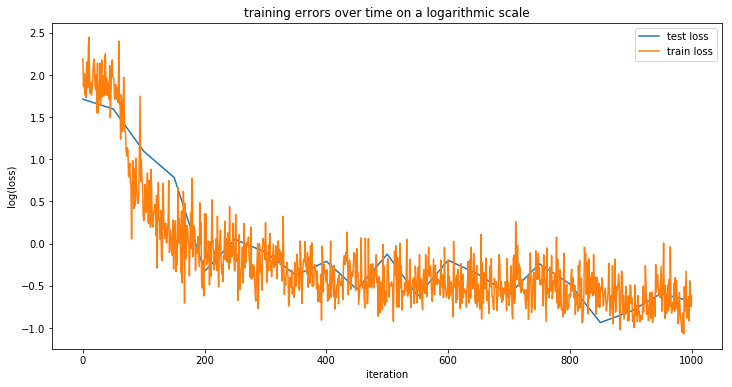

In [6]:
# 开始训练
train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())
for t in range(iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("step {}/{}, train loss: {},test loss {}".format(t,iters,train_loss,test_loss))
plt.figure(figsize=(12,6))
plt.plot(np.array(range(0,len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1),
         np.log(test_losses),label = "test loss")
plt.plot(np.log(train_losses),label = 'train loss')
plt.title("training errors over time on a logarithmic scale")
plt.xlabel("iteration")
plt.ylabel('log(loss)')
plt.legend(loc='best')
plt.show()

对于 decode_input 的输入要重点说明一下,将其第一个序列的输入变为 0, 作为起始输入的标记,接上后续的 Y 数据(未来序列) 作为解码器 Decoder 来输入, 由于第一个序列被占用了,保证总长度不变的情况下,Y 的最后一个序列没有作为 Decoder 的输入,但是输出时会有未来序列预测的全部序列值,并在计算 loss 时与真实值 Y 进行平方差.

### 4 基于注意力的 seq2seq

#### (1) attention_seq2seq 介绍
注意力机制,即在生成每个词时,对不同的输入词给予不同的关注权重,如下图所示,右侧序列为输入序列,上方序列是输出序列.在注意力机制下,对于一个输出网络会自动学习与其对应的输入关系的权重.
<center><img src="./img/13/2.png"/></center>
<br/>
在训练过程中,模型会通过注意力机制把某个输出对应的所有输入列出来,学习其关系并更新到权重上,如上图,"you" 对应的一列 (80,5,0,15,0),就是模型在生成 "you" 这个词时的概率分布,最大值对应的输入为 "你",说明模型生成 "you" 时,最关心的输入词是 "你". 这样在预测时,该机制就会根据输入及其权重,反向推出其更有可能的预测值了.

注意力机制是在原有的 seq2seq 中的 encoder 与 decoder 框架中修改而来,具体结构如下:
<center><img src="./img/13/3.png" width="600"/></center>
<br/>
修改后的模型特点是序列中每个时刻 Encoder 生成的 c,都要参与 Decoder 中解码的各个时刻,而不是只参与初始时刻.当然对于生成的结果节点 c, 参与到 Decoder 的每个序列运算都会经过权重 w,那么这个 w 就可以以 loss 的方式通过优化器来调节了,最终会逐步逼近与它紧密的那个词.添加了 Attention 注意力分配机制后,使得 Decoder 在生成新的 target sequence 时,能得到之前 Encoder 编码阶段每个字符的隐藏层的信息向量 hidden state, 使得新生成的序列准确度提高.

#### (2) Tensorflow 中的 attention_seq2seq
在 Tensorflow 中也有关于带注意力机制的 Seq2Seq 定义, 封装后的 Seq2Seq 与前面的 basic_rnn_seq2seq 差不多,具体函数人如下:
```python
tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
          encoder_inputs,
          decoder_inputs,
          cell,
          num_encoder_symbols,
          num_decoder_symbols,
          embedding_size,
          num_heads = 1,
          output_projection = None,
          feed_previous = False)
                                                        
参数说明如下:
+ encoder_inputs: 一个形状为 [batch_size] 的 list
+ decoder_inputs: 一个形状为 [batch_size] 的 list
+ cell: 定义的 cell 网络
+ num_encoder_symbols: 输入数据对应的词总个数
+ num_decoder_symbols: 输出数据对应的词总个数
+ embedding_size: 每个输入对应的词向量编码大小
+ num_heads: 从注意力状态里读取的个数
+ output_projection: 对输出结果是否进行全连接的维度转化,如果需要转化,则传入全连接对应的 w 和 b
+ feed_previous: 为 True 时,表明只有第一个 Decoder 输入以 Go 开始,其他都使用前面的状态,如果为 False 时,每个 Decoder 的输入都会以 Go 开始, Go 为自己定义模型时定义一个起始符,一般用 0 或 1 来表示
```

#### (3) seq2seq 中桶(bucket) 的实现机制
在 seq2seq 模型中,由于输入,输出都是可变长的,这就给计算带来了很大的效率影响,在 tensorflow 中使用一个 "桶"(bucket) 的机制来解决这个问题,思想就是初始化几个 bucket,对数据预处理,按照每个序列的长短,将其放在不同的 bucket中,小于 bucket size 部分统一用 0 填充对齐,之后就可以惊醒不同的 bucket 的批处理计算.其定义如下:
```python
tf.contrib.legacy_seq2seq.model_with_buckets(
    encoder_inputs,
    decoder_inputs,
    targets,
    weights,
    buckets,
    seq2seq,
    softmax_loss_function=None,
    per_example_loss=False)
   
参数说明如下:
+ encoder_inputs: 一个形状为 [batch_size] 的 list
+ decoder_inputs: 一个形状为 [batch_size] 的 list,作为解码器部分的输入
+ targets: 最终输出结果的 label
+ weights: 传入的权重值,必须与 decoder_inputs 的 size 相同
+ buckets: 传入的桶,描述为 [(xx,xx),(xx,xx),...],元组第一个数为输入的size,第二个数为输出的 size
+ seq2seq: 带有 seq2seq 结构的网络,以函数名的方式传入,在 seq2seq 里可以载入定义的 cell 网络.
+ softmax_loss_function: 是否使用自己指定的 loss 函数
+ per_example_loss: 是否对每个样本求 loss
```


### 5 Seq2Seq 注意力模型简单示例

#### (1) 数据生成

In [7]:
def get_batch(inputs, max_sequence_length=None):
    """
    inputs: [batch_size,timesteps,cell_data]
    max_sequence_length: 最大的 timesteps
    返回值:
        inputs_time_major: [timesteps,batch_size,cell_data]
        sequence_lengths: 序列长度列表
    """
    # 输入数据的长度可能不一样,所以需要事先计算每个序列的长度
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    # 获取最大序列长度
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    # 长度不够使用 0 来填充,先按照最大长度填充
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length],dtype=np.int32)
    # 将有数据的加入到输入序列中
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element
    
    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths

In [8]:
def random_sequences(length_from, length_to, vocab_lower, vocab_upper,batch_size):
    """
    产生一个随机的数字序列,形状为[batch_size,timesteps,cell_data],其中timesteps是变化的,
    序列长度: [length_from, length_to],
    随机数字上下限: [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
        raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to+1)
    # 这里使用循环,可以一直产生序列
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]

#### (2) 构建 Seq2Seq 模型

In [9]:
class Seq2SeqModel:
    def __init__(self):
        self.encoder_hidden_unit = 150
        self.decoder_hidden_unit = 150
        self.max_n_times_in = 3
        self.max_n_times_out = 4
        self.n_features = 12
        self.time_major = True
        self.is_attention = False
        self.batch_size = 100

        self.create_embeddings()
        encoder_outputs, encoder_state = self.create_encoder()
        decoder_outputs, decoder_state = self.create_decoder(encoder_outputs,
                                                             encoder_state)

        decoder_logits = self.create_fully_connected_layer(decoder_outputs)
        self.loss = self.create_loss(decoder_logits)

        self.train_op = self.create_optimizer()
        self.summaries()

    def create_embeddings(self):
        self.encoder_inputs = tf.placeholder(shape=[None, None],
                                             dtype=tf.int32,
                                             name='encoder_inputs')
        self.decoder_inputs = tf.placeholder(shape=[None, None],
                                             dtype=tf.int32,
                                             name='decoder_inputs')
        self.decoder_targets = tf.placeholder(shape=[None, None],
                                              dtype=tf.int32,
                                              name='decoder_targets')
        self.decoder_full_length = tf.placeholder(shape=(None,),
                                                  dtype=tf.int32,
                                                  name='decoder_full_length')
        # 这里表示词汇大小为: n_features
        # 每个词对应的向量维度: encoder_hidden_unit
        embeddings = tf.Variable(tf.random_uniform(
                                    [self.n_features,
                                     self.encoder_hidden_unit],
                                    -1.0, 1.0), dtype=tf.float32)

        # 将数值数字编号输入,转化成对应的向量输入
        self.encoder_embeddings = tf.nn.embedding_lookup(embeddings,
                                                         self.encoder_inputs)
        self.decoder_embeddings = tf.nn.embedding_lookup(embeddings,
                                                         self.decoder_inputs)
        # 这里的预测目标值还是使用的 one_hot 编码
        self.decoder_targets_embeddings = tf.one_hot(self.decoder_targets,
                                                     self.n_features,
                                                     dtype=tf.float32)

    def create_encoder(self):
        # Build RNN cell
        with tf.variable_scope("encoder") as scope:
            encoder_cell = tf.contrib.rnn.LSTMCell(self.encoder_hidden_unit)
            # encoder_cell = tf.contrib.rnn.GRUCell(self.encoder_hidden_unit)
            # 由于使用 tf.nn.dynamic_rnn 所以 inputs 形状为[batch_size,timesteps,cell_data]
            encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
                cell=encoder_cell,
                inputs=self.encoder_embeddings,
                dtype=tf.float32,
                time_major=self.time_major,
                swap_memory=True,
                scope=scope
            )

        return encoder_outputs, encoder_state

    def create_decoder(self, encoder_outputs, encoder_state):
        with tf.variable_scope("decoder") as decoder_scope:
            # 新版接口需要定义的 helper 类
            helper = tf.contrib.seq2seq.TrainingHelper(
                    self.decoder_embeddings,
                    self.decoder_full_length,
                    time_major=self.time_major)

            if self.is_attention:
                decoder_cell = tf.contrib.rnn.LSTMCell(self.decoder_hidden_unit)
                # decoder_cell = tf.contrib.rnn.GRUCell(self.decoder_hidden_unit)
                if self.time_major:
                    # [batch_size, max_time, num_nunits]
                    attention_states = tf.transpose(encoder_outputs, [1, 0, 2])
                else:
                    attention_states = encoder_outputs
                # 使用attention机制的输入为 encoder_outputs
                # 其实 Attention 就是一个矩阵,所以需要指定维度
                attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                    self.decoder_hidden_unit, attention_states)
                # 把 Attention 包装,主要是定义 decoder_cell 和 decoder_initial_state
                # 把以前的 decoder_cell 包装了一层 Attention
                decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                    decoder_cell, attention_mechanism,
                    attention_layer_size=self.decoder_hidden_unit)
                # 设置初始化状态
                decoder_initial_state = (
                     decoder_cell.zero_state(tf.size(self.decoder_full_length),
                                                      dtype=tf.float32).clone(
                                                        cell_state=encoder_state))
            else:
                decoder_cell = tf.contrib.rnn.LSTMCell(self.decoder_hidden_unit)
                decoder_initial_state = encoder_state
            # 将封装好 Attention 的 decoder_cell 交给 BasicDecoder,这样就形成一个最简单的decoder
            decoder = tf.contrib.seq2seq.BasicDecoder(
                cell=decoder_cell,
                helper=helper,
                initial_state=decoder_initial_state)

            outputs, last_state, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=self.time_major)

        return outputs.rnn_output, last_state
    # 定义全连接网络
    def create_fully_connected_layer(self, decoder_outputs):
        decoder_logits = (tf.contrib.layers.linear(decoder_outputs,
                                                   self.n_features))

        self.decoder_prediction = tf.argmax(decoder_logits, 2)

        return decoder_logits

    def create_loss(self, decoder_logits):
        stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
             labels=self.decoder_targets_embeddings,
             logits=decoder_logits)

        loss = (tf.reduce_mean(stepwise_cross_entropy))
        return loss

    def create_optimizer(self):
        return tf.train.AdamOptimizer().minimize(self.loss)

    def summaries(self):
        with tf.name_scope("sumaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)

            self.summary_op = tf.summary.merge_all()
    # 迭代运算
    def update(self, sess, encoder_inputs,
               decoder_inputs, decoder_targets, decoder_full_length):
        return sess.run([self.train_op, self.loss, self.summary_op],
                        feed_dict={
                            self.encoder_inputs: encoder_inputs,
                            self.decoder_inputs: decoder_inputs,
                            self.decoder_targets: decoder_targets,
                            self.decoder_full_length: decoder_full_length})
    # 预测结果
    def predict(self, sess, encoder_inputs,
                decoder_inputs, decoder_full_length):
        pred = sess.run([self.decoder_prediction],
                        feed_dict={self.encoder_inputs: encoder_inputs,
                                   self.decoder_inputs: decoder_inputs,
                                   self.decoder_full_length: decoder_full_length
                                   })

        return pred

#### (3) 模型使用

In [10]:
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
seq2seq = Seq2SeqModel()

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # batch_ 的为 [[9,8,7],[9,8,7],...,[9,8,7]],输入的shape(5,3),[batch_size,timesteps]
    batch_ = [[9,8,7]] *5
    # 将输入数据的形状转换为 shape=(3,5),[timesteps,batch_size]
    batch_,batch_length_ = get_batch(batch_)
    print("batch_encode: \n" + str(batch_))
    
    din_, dlen_ = get_batch(np.ones(shape=(5,1), dtype=np.int32), max_sequence_length=4)
    
    print('decoder inputs: \n' + str(din_))
    print('decoder input size: \n' + str(batch_.shape[0]))
    out_length = np.asarray([din_.shape[0]]*din_.shape[1])
    print('decoder inpput full length: \n' + str(out_length))
    print('Predict results: \n' + str(seq2seq.predict(sess, batch_, din_,out_length)))

batch_encode: 
[[9 9 9 9 9]
 [8 8 8 8 8]
 [7 7 7 7 7]]
decoder inputs: 
[[1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
decoder input size: 
3
decoder inpput full length: 
[4 4 4 4 4]
Predict results: 
[array([[1, 1, 1, 1, 1],
       [4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4],
       [7, 7, 7, 7, 7]])]


In [13]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=12, vocab_lower=2, vocab_upper=10, batch_size=batch_size)
print('head of the batch')
for seq in next(batches)[:10]:
    print(seq)

head of the batch
[9, 3, 7, 9, 3, 7, 2, 4, 2, 3, 4]
[3, 8, 7, 2, 2, 2, 4, 6]
[8, 9, 5, 2, 7, 6]
[3, 8, 8, 6, 4, 3, 3, 6, 9, 7]
[6, 7, 7, 6, 4]
[4, 6, 9, 8]
[5, 7, 9, 7, 8, 3, 7, 5, 9, 8, 2, 2]
[9, 3, 5, 6]
[6, 6, 7]
[4, 7, 4, 6]


In [14]:
EOS = 1

def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = get_batch(batch)
    decoder_targets_, _ = get_batch([(sequence)+[EOS] for sequence in batch])
    
    decoder_inputs_, _ = get_batch([[EOS] + (sequence) for sequence in batch])
    
    decoder_full_length = np.asarray([decoder_inputs_.shape[0]] * decoder_inputs_.shape[1])
    
    return encoder_inputs_, decoder_inputs_,decoder_targets_, decoder_full_length

In [15]:
loss_track = []

max_batches = 3001
batches_in_epoch = 1000

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for batch in range(max_batches):
        encoder_inputs, decoder_inputs, decoder_targets, decoder_full_length = next_feed()
        
        train_op, loss, summary_op = seq2seq.update(sess, encoder_inputs, decoder_inputs, 
                                                    decoder_targets, decoder_full_length)
        loss_track.append(loss)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('     minibatch loss: {}'.format(loss))
            predict_ = seq2seq.predict(sess, encoder_inputs, decoder_inputs, decoder_full_length)
        
            for i, (inp, pred) in enumerate(zip(np.array(encoder_inputs).T, np.array(predict_).T)):
                print('     sample {}:'.format(i +1))
                print('         input    > {}'.format(inp))
                print('         predicted> {}'.format(np.array(pred).T[0]))
                if i >= 2:
                    break;
            print()

batch 0
     minibatch loss: 2.548619270324707
     sample 1:
         input    > [4 6 2 8 6 4 2 0 0 0 0 0]
         predicted> [7 7 8 8 0 0 0 0 0 0 0 0 0]
     sample 2:
         input    > [8 3 8 5 3 4 7 4 0 0 0 0]
         predicted> [7 7 7 7 7 7 0 0 0 0 0 0 0]
     sample 3:
         input    > [3 8 3 2 0 0 0 0 0 0 0 0]
         predicted> [7 7 7 7 0 0 0 0 0 0 0 0 0]

batch 1000
     minibatch loss: 0.08899135887622833
     sample 1:
         input    > [8 5 9 5 7 0 0 0 0 0 0 0]
         predicted> [8 5 9 5 7 1 0 0 0 0 0 0 0]
     sample 2:
         input    > [9 4 6 5 4 5 4 0 0 0 0 0]
         predicted> [9 4 6 5 4 5 4 1 0 0 0 0 0]
     sample 3:
         input    > [3 8 5 6 3 8 6 4 6 0 0 0]
         predicted> [3 8 5 6 3 8 6 4 6 1 0 0 0]

batch 2000
     minibatch loss: 0.038491129875183105
     sample 1:
         input    > [2 4 7 6 3 4 3 5 0 0 0 0]
         predicted> [2 4 7 6 3 4 3 5 1 0 0 0 0]
     sample 2:
         input    > [6 4 6 6 7 0 0 0 0 0 0 0]
         predicted> [6

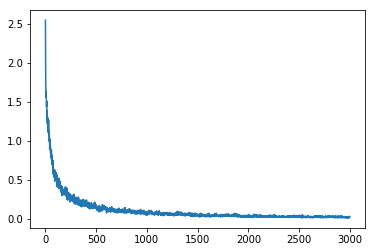

In [17]:
plt.plot(loss_track)